In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  

In [2]:
def extract_model_info(filename):
    """
    Extracts the model name and version from the filename.
    Example:
        'resolved_Model1_0_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.0'
        'resolved_Model1_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.1'
    """
    # Regular expression to capture 'Model' followed by a number, an underscore, and another number
    match = re.search(r'resolved_(Model)(\d+)_(\d+)_MW', filename)
    if match:
        model_prefix = match.group(1)      # 'Model'
        model_number = match.group(2)      # e.g., '1'
        model_version = match.group(3)     # e.g., '0', '1'
        # Format as 'Model 1.0', 'Model 1.1', etc.
        formatted_model = f"{model_prefix} {model_number}.{model_version}"
        return formatted_model
    else:
        return 'Unknown'
def process_h5_file(filepath):
    """
    Processes a single .h5 file and extracts the necessary parameters.
    Returns a pandas DataFrame with the extracted data and model information.
    """
    # Extract the model from the filename
    filename = os.path.basename(filepath)
    model = extract_model_info(filename)
    
    cats, units = h5io.load_array(filepath, 'cat')
    
    data = {
        'Name': cats['Name'],
        'Frequency': cats['Frequency'],
        'Amplitude': cats['Amplitude'],
        'FrequencyDerivative': cats['FrequencyDerivative'],
        'SNR': np.sqrt(cats['snr2']),
        'Eccentricity': cats['Eccentricity'],
        'Inclination': cats['Inclination'],
        'Polarization': cats['Polarization'],
        'EclipticLatitude': cats['EclipticLatitude'],
        'EclipticLongitude': cats['EclipticLongitude'],
        'InitialPhase': cats['InitialPhase'],
        'Model': model 
    }
    
    df = pd.DataFrame(data)
    
    return df
def compile_data_from_folder(folder_path):
    """
    Compiles data from all .h5 files in the specified folder into a single DataFrame.
    """
    all_data = []
    
    # List all .h5 files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.h5') and filename.startswith('resolved_'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = process_h5_file(filepath)
                all_data.append(df)
                print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    if all_data:
        # Concatenate all DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No .h5 files found or no data extracted.")
        return pd.DataFrame()  # Return empty DataFrame if no data

In [3]:
resolved_folder_path = '/Users/irwin/Documents/GitHub/lisa-ml/data/resolved_binaries/'
resolved_df = compile_data_from_folder(resolved_folder_path)
resolved_df['Class'] = resolved_df['Name'].str.extract(r'MW_(DWD|NSWD)')
selected_features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

resolved_df = resolved_df.dropna(subset=selected_features + ['Class'])

# Encode labels: DWD=0, NSWD=1
label_encoder = LabelEncoder()
resolved_df['Class'] = label_encoder.fit_transform(resolved_df['Class'])
resolved_df['Frequency_mHz'] = resolved_df['Frequency'] * 1000
resolved_df['FrequencyDerivative_log10'] = np.log10(resolved_df['FrequencyDerivative'])
resolved_df['EclipticLatitude_sin'] = np.sin(resolved_df['EclipticLatitude'])
resolved_df['Amplitude_log10'] = np.log10(resolved_df['Amplitude'])
resolved_df['Inclination_cos'] = np.cos(resolved_df['Inclination'])

cols_to_remove = ['Frequency', 'FrequencyDerivative', 'EclipticLatitude', 'Amplitude', 'Inclination']
resolved_df.drop(columns=cols_to_remove, inplace=True)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


In [4]:
resolved_df

,Name,SNR,Eccentricity,Polarization,EclipticLongitude,InitialPhase,Model,Class,Frequency_mHz,FrequencyDerivative_log10,EclipticLatitude_sin,Amplitude_log10,Inclination_cos
0,MW_DWD 0,40.929675,0.000000,0.188781,-1.796378,1.743567,Model 2.1,0,5.831488,-15.037016,-0.351313,-22.392716,0.130661
1,MW_DWD 305,12.663876,0.000000,5.567065,2.669358,0.614617,Model 2.1,0,1.032685,-17.988213,-0.048640,-22.131877,-0.567883
2,MW_DWD 336,7.494779,0.000000,5.029394,-1.943069,1.035197,Model 2.1,0,1.394106,-17.510344,-0.589556,-22.784182,0.922483
3,MW_DWD 343,12.629021,0.000000,0.959902,-1.823988,1.642656,Model 2.1,0,1.562902,-17.328345,-0.415794,-22.671332,0.937526
4,MW_DWD 345,9.684461,0.000000,6.137735,-1.674099,0.222782,Model 2.1,0,1.614743,-17.276382,-0.096953,-22.811105,0.914601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168721,MW_NSWD_ecc1 36818,14.337639,0.858406,0.315960,-1.551163,3.953830,Model 1.3,1,1.844884,-16.934493,-0.130805,-22.787111,0.997029
168722,MW_NSWD_ecc1 46118,9.564295,0.615259,5.096369,-2.345533,2.725020,Model 1.3,1,2.232109,-16.511926,-0.464487,-23.014052,-0.807019
168723,MW_NSWD_ecc1 52477,9.630959,0.781611,1.463049,-1.767237,6.199689,Model 1.3,1,2.260619,-16.750075,-0.155333,-23.048656,-0.847065
168724,MW_NSWD_ecc1 52477,9.557340,0.781611,1.463049,-1.767237,6.199689,Model 1.3,1,2.363374,-16.730770,-0.155333,-23.083515,-0.847065


In [5]:
selected_features = [
    'Frequency_mHz', 
    'Amplitude_log10', 
    'FrequencyDerivative_log10', 
    'SNR', 
    'Eccentricity',
    'EclipticLatitude_sin',
    'Inclination_cos',
    'Polarization',
    'EclipticLongitude',
    'InitialPhase'
]

X = resolved_df[selected_features]
y = resolved_df['Class'] 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [6]:
rf_clf = RandomForestClassifier(n_estimators=100,      # number of trees
                                max_depth=None,         # expand trees until leaves are pure if None
                                criterion='gini',       # or use 'entropy'
                                random_state=42, 
                                n_jobs=-1)              # use all available cores

rf_clf.fit(X_train, y_train)


y_pred = rf_clf.predict(X_val)


cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Confusion Matrix:
[[26682     0]
 [   59   255]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26682
           1       1.00      0.81      0.90       314

    accuracy                           1.00     26996
   macro avg       1.00      0.91      0.95     26996
weighted avg       1.00      1.00      1.00     26996



# With Bayesian Classification

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
g2_train = rf_clf.predict_proba(X_train)[:,1].reshape(-1,1)

calibrator = LogisticRegression().fit(g2_train, y_train)

# 3) Apply to test set:
g2_test = rf_clf.predict_proba(X_val)[:, 1].reshape(-1, 1)
y_proba_calibrated = calibrator.predict_proba(g2_test)[:, 1]

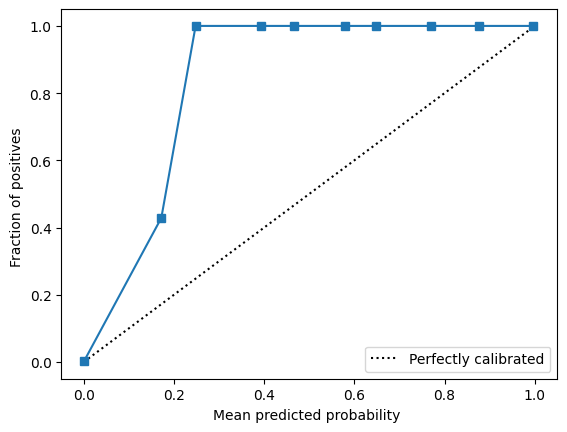

Brier score (logistic‐calibrated): 0.002


In [10]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics       import brier_score_loss
import matplotlib.pyplot    as plt

# Calibration curve for our bespoke calibrator
prob_true, prob_pred = calibration_curve(y_val, y_proba_calibrated, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba_calibrated)
disp.plot()
plt.show()

# Brier score
brier = brier_score_loss(y_val, y_proba_calibrated)
print(f"Brier score (logistic‐calibrated): {brier:.3f}")